# Plotting SHARP keywords and images with python

In this notebook, we will be plotting keywords and images, from data taken by the Helioseismic and Magnetic Imager (HMI) instrument on NASA's Solar Dynamics Observatory (SDO) satellite. SDO takes about a terabyte and a half of data a day, which is more data than any other satellite in the NASA Heliophysics Division. 

Data from the HMI and Atmospheric Imaging Assembly (AIA) instruments aboard SDO are stored at Stanford University. The metadata are stored in a pSQL database called the Data Record Management System, or DRMS. The image data are stored separately, in storage units called the Storage Unit Management System, or SUMS. Data are merged together, upon export from both systems, as FITS files. DRMS and SUMS together constitute the Joint Science Operations Center, or JSOC.

The easiest way to access SDO HMI and AIA data is via the python `drms` module, available at [PyPI](https://pypi.python.org/pypi/drms). In addition to the numerous tutorials on both the [Read the Docs](https://drms.readthedocs.io/en/stable/tutorial.html) and [Github](https://github.com/kbg/drms/tree/master/examples), all the examples below utilize the `drms` module. First we'll import the module, and some others:

In [1]:
import drms
import json, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick
from datetime import datetime as dt_obj
import urllib
from astropy.io import fits
from sunpy.visualization.colormaps import color_tables as ct
from matplotlib.dates import *
import matplotlib.image as mpimg
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format='retina'

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.

In [2]:
import drms
c = drms.Client()

The `Client()` class allows one to access both metadata and image data simultaneously via a data series. A data series contains all of particular type of data — e.g. there is a series for continuum intensity data, another for magnetic field data, and so forth. Read Section 4 of the [SDO Analysis Guide](https://www.lmsal.com/sdodocs/doc/dcur/SDOD0060.zip/zip/entry/) for more information about how to build a data series query. For example, to find all the SHARP data series, execute the following regular expression query:

In [3]:
c.series(r'hmi\.sharp_')

['hmi.sharp_720s',
 'hmi.sharp_720s_nrt',
 'hmi.sharp_cea_720s',
 'hmi.sharp_cea_720s_nrt']

In [4]:
# Set a series
si = c.info('hmi.sharp_cea_720s')

To find more information about the FITS header keywords that belong to any given series, we can use the following command:

In [5]:
si.keywords

,type,recscope,defval,units,note,linkinfo,is_time,is_integer,is_real,is_numeric
name,,,,,,,,,,
cparms_sg000,string,variable,compress Rice,none,,None,False,False,False,False
magnetogram_bzero,double,variable,0,none,,None,False,False,True,True
magnetogram_bscale,double,variable,0.1,none,,None,False,False,True,True
cparms_sg001,string,variable,,none,,None,False,False,False,False
bitmap_bzero,double,variable,0,none,,None,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...
ERRMSHA,float,variable,nan,Degrees,Error in Mean shear angle for B_total,None,False,False,True,True
ERRUSI,float,variable,nan,Amperes,Error in Total unsigned vertical current,None,False,False,True,True
DOFFSET,int,variable,-2147483648,Gauss,Constant value added to the noise mask for dis...,None,False,True,False,True


To find more information about the FITS image data, or segments, that belong to any given series, we can use the following command:

In [6]:
# To see all the segments associated with the series hmi.sharp_cea_720s:
si.segments

,type,units,protocol,dims,note
name,,,,,
magnetogram,int,Gauss,fits,VARxVAR,Line-of-sight magnetogram in CEA projection
bitmap,char,Enumerated,fits,VARxVAR,Mask for the patch in CEA coordinates
Dopplergram,int,m/s,fits,VARxVAR,Dopplergram in CEA projection
continuum,int,DN/s,fits,VARxVAR,Intensitygram in CEA projection
Bp,int,Gauss,fits,VARxVAR,"B_phi, positive westward"
Bt,int,Gauss,fits,VARxVAR,"B_theta, positive southward"
Br,int,Gauss,fits,VARxVAR,"B_r, positive up"
Bp_err,int,Gauss,fits,VARxVAR,Standard deviation of B_phi
Bt_err,int,Gauss,fits,VARxVAR,Standard deviation of B_theta


## Plotting the metadata

The query below retrieves both metadata and image data for active region 11158, which produced an X2.2-class flare on February 15, 2011 at 1:56 UT, from the SHARP data series. The [SHARP data series](https://link.springer.com/article/10.1007%2Fs11207-014-0529-3) include patches of vector magnetic field data taken by the HMI instrument. These patches encapsulate automatically-detected active regions that are tracked throughout the entirety of their disk passage. The `c.query()` method takes three arguments:
1. The first argument is the data series. In the example below, the data series is called `hmi.sharp_cea_720s`. This series is appended with two prime keys: the HARP number (in this case, 377) and the time range (in this case, 2011.02.14_15:00:00/12h). These two prime keys appear in the first two brackets. The HARP number refers to the active region number (see [here](http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt) for a mapping between HARP numbers and NOAA active region numbers). A prime key, or set of prime keys, is a unique identifier. The third bracket, with the argument `[? (QUALITY<65536) ?]`, filters out data where the value of the `QUALITY` keyword is greater than 65536. (See [here](http://jsoc.stanford.edu/doc/data/hmi/Quality_Bits/QUALITY.txt) for the definition of the `QUALITY` keyword). While this third bracket is not necessary, it can be a powerful tool for filtering data based on keyword values.
2. The second argument in the search query is a list of keywords. In this example, we will query for the keywords `T_REC`, `USFLUX`, and `ERRVF`. 
3. The third argument in the search query is a list of segments. In this example, we will query for the segment `Br`, or the radial component of the photospheric magnetic field.

In [7]:
keys, segments = c.query('hmi.sharp_cea_720s[377][2011.02.14_15:00:00/12h][? (QUALITY<65536) ?]', key='T_REC, USFLUX, ERRVF', seg='Br')

To convert the keyword `T_REC` into a datetime object, we can use the function below.

In [8]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [9]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

Now for some plotting! matplotlib.pyplot generates two objects: a figure and axes. The data are ascribed to the axes. The time axes in particular requires some formatting; in order to free it of clutter, we'll plot tick marks every three hours and label them accordingly.

Text(0.5, 1.0, 'total unsigned flux starting at 2011-02-14 15:00:00 UT')

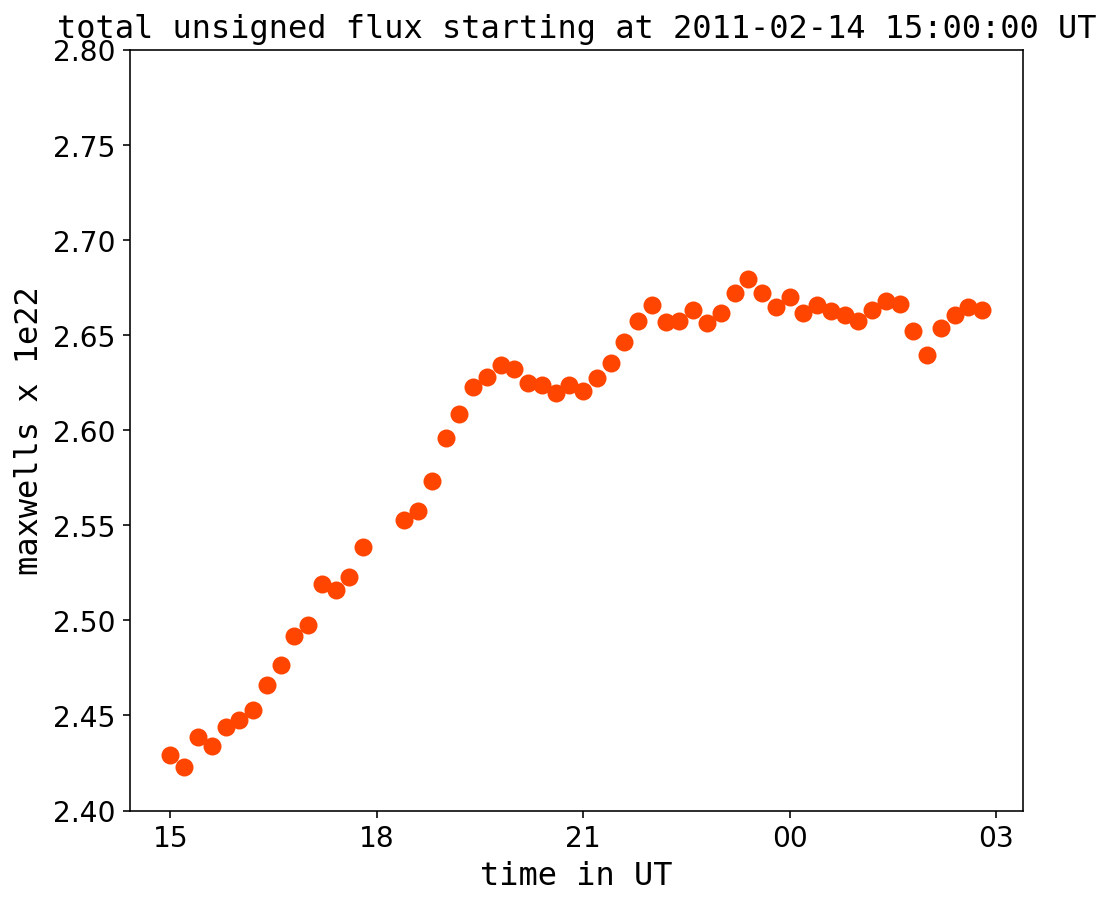

In [10]:
fig, ax = plt.subplots(figsize=(8,7))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# ascribe the data to the axes
ax.plot(t_rec, (keys.USFLUX)/(1e22),'o',**marker_style)
ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='',color=orangered)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [3] # only show every 3 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set yrange 
ax.set_ylim([2.4,2.8])

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('maxwells x 1e22',**text_style)
ax.set_title('total unsigned flux starting at '+str(t_rec[0])+' UT',**text_style) # annotate the plot with a start time

## Querying the data

The example above shows a simple query for 12 hours of data from one HARPNUM. But we can also perform more complex queries to identify active regions of interest. Here are a few examples.

**Example 1.** Suppose we want to create a magnetic field model of an active region and we need observations of a strong-field active region near disk center. This query identifies strong-field regions near disk center during a two year period. We define strong active regions as those with a total unsigned flux (`USFLUX`) greater than $4x10^{22}$ Mx and near disk center as those with a Carrington Longitude (`CRLN_OBS`) less than $1^{\circ}$. The two year period spans between January 2014 and January 2016.

In [11]:
keys = c.query('hmi.sharp_cea_720s[][2014.01.01 - 2016.01.01][? (CRLN_OBS < 1) AND (USFLUX > 4e22) ?]', key='T_REC, HARPNUM, USFLUX, CRLT_OBS, CRLN_OBS, AREA_ACR')

In [12]:
keys

,T_REC,HARPNUM,USFLUX,CRLT_OBS,CRLN_OBS,AREA_ACR
0,2014.05.04_14:48:00_TAI,4071,4.007906e+22,-3.818258,0.045204,1297.351685
1,2014.11.11_06:00:00_TAI,4800,4.004017e+22,3.297165,0.676486,1207.938232
2,2014.11.11_06:12:00_TAI,4800,4.023450e+22,3.295724,0.567313,1194.579590
3,2014.11.11_06:24:00_TAI,4800,4.050183e+22,3.294308,0.458156,1198.369873
4,2014.11.11_06:36:00_TAI,4800,4.070347e+22,3.292919,0.349014,1204.132935
5,2014.11.11_06:48:00_TAI,4800,4.081056e+22,3.291558,0.239885,1208.038818
6,2014.11.11_07:00:00_TAI,4800,4.094752e+22,3.290226,0.130767,1199.290039
7,2014.11.11_07:12:00_TAI,4800,4.113331e+22,3.288925,0.021658,1222.337891
8,2015.02.01_05:00:00_TAI,5127,4.801844e+22,-6.020030,0.985052,2273.071289
9,2015.02.01_05:12:00_TAI,5127,4.817782e+22,-6.020372,0.875986,2271.228516


**Example 2.** Suppose we are doing a study on flux emergence and we want to identify active regions that live for a long time. This query identifies long-lived active regions within a six year period. We define long-lived active regions as those with a minimum number of observations (`N_PATCH1`) equal to 1800 (1800 observations with a 12 minute gap between observations means a minimum observation time of 15 days). The six year period spans between January 2012 and January 2018. The `T_FRST1=T_REC` clause identifies the first observation time in the sequence.

In [13]:
keys = c.query('hmi.sharp_cea_720s[][2012.01.01 - 2018.01.01][? (N_PATCH1 > 1800) AND (T_FRST1=T_REC) ?]', key='T_REC, HARPNUM, NOAA_ARS, N_PATCH1, AREA_ACR')

In [14]:
keys

,T_REC,HARPNUM,NOAA_ARS,N_PATCH1,AREA_ACR
0,2012.07.04_03:24:00_TAI,1834,"11519,11520,11521",1820,28.082201
1,2012.07.22_21:12:00_TAI,1879,"11529,11530,11532,11533,11536",1883,24.621628
2,2012.07.30_22:24:00_TAI,1907,"11538,11539,11540,11541,11544,11545",1809,18.218309
3,2012.09.17_23:24:00_TAI,2040,"11575,11577,11583",1986,124.659348
4,2013.04.26_15:36:00_TAI,2696,"11732,11734",1846,18.187544
5,2013.06.12_17:24:00_TAI,2852,"11769,11770,11771,11772,11774,11775",1864,3.143462
6,2013.12.30_21:00:00_TAI,3563,"11943,11944",1822,2.208999
7,2014.01.17_09:00:00_TAI,3647,"11958,11959,11960,11963,11964",1813,18.883802
8,2014.02.21_04:36:00_TAI,3784,"11987,11989,11993,11994,12001",2018,30.495930
9,2014.03.14_21:24:00_TAI,3856,"12008,12010,12012,12015,12019,12023",1838,21.218081


**Example 3.** Suppose we are doing a study on flare prediction. [Schrijver (2007)](https://doi.org/10.1086/511857) derived a parameter, called $R$, which quantifies the flux near an active region neutral line. The study concluded that an active region will flare if the log of R is greater than 5. [Bobra & Couvidat (2015)](https://dx.doi.org/10.1088/0004-637X/798/2/135) also identified a large total unsigned helicity as a relevant characteristic of flaring active regions. This query identifies active regions with a log of R (`R_VALUE`) greater than 5.5 or a total unsigned helicity (`TOTUSJH`) greater than 8900 $\frac{G^{2}}{m}$ during a two year period between January 2012 and January 2014. 

In [15]:
keys = c.query('hmi.sharp_cea_720s[][2012.01.01 - 2014.01.01][? (R_VALUE > 5.5 AND R_VALUE < 6.0) OR (TOTUSJH >= 8900)?]', key='T_REC,HARPNUM,R_VALUE,TOTUSJH')

In [16]:
keys

,T_REC,HARPNUM,R_VALUE,TOTUSJH
0,2012.07.09_15:12:00_TAI,1834,5.249,8920.152
1,2012.07.09_15:36:00_TAI,1834,5.239,8954.800
2,2012.07.09_15:48:00_TAI,1834,5.253,8923.751
3,2012.07.09_16:00:00_TAI,1834,5.252,8902.096
4,2012.07.09_16:12:00_TAI,1834,5.251,8918.384
5,2012.07.09_16:24:00_TAI,1834,5.256,8901.315
6,2012.07.09_16:36:00_TAI,1834,5.261,8928.521
7,2012.07.09_21:12:00_TAI,1834,5.264,8907.350
8,2012.07.09_21:48:00_TAI,1834,5.271,8910.375
9,2012.07.09_22:12:00_TAI,1834,5.272,8931.835


## Plotting the image data

We can also query for and view image data by downloading the unmerged FITS file, which means that the header metadata has not been merged with the image data, via `astropy`. This is the quickest and easiest option as the `drms.Client()` class can query the header and image data independently, there is no need to store FITS files locally, and there is no need to wait for the exportdata system to generate FITS files. The image below shows for the radial component of the photospheric magnetic field.

In [17]:
url = 'http://jsoc.stanford.edu' + segments.Br[54]  # add the jsoc.stanford.edu suffix to the segment name
photosphere_image = fits.open(url)                  # download the data

The dimensions of this image are 377 by 744 .


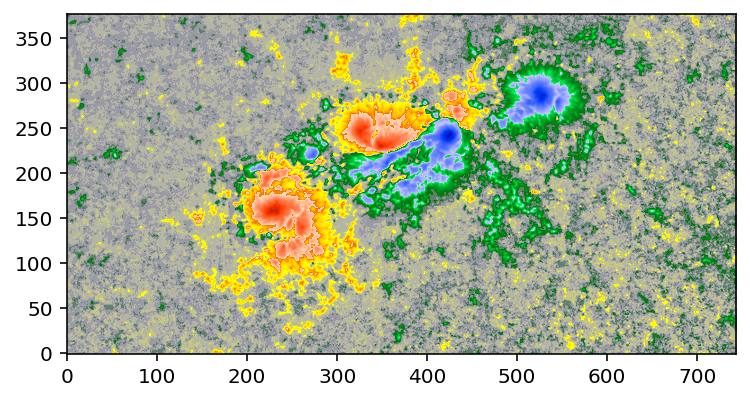

In [18]:
hmimag = plt.get_cmap('hmimag')
plt.imshow(photosphere_image[1].data,cmap=hmimag,origin='lower',vmin=-3000,vmax=3000)
print('The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'.')

## Exporting data

The JSOC allows users to export data as FITS files, jpg images and movies in mp4 or mpg format. 

<b> n.b. The code below will only work with a valid e-mail address. </b> In order to obtain one, users must register on the [JSOC exportdata website](http://jsoc.stanford.edu/ajax/exportdata.html). It is worthwhile to have a read around that webpage before using the `drms` module to export data.

In [19]:
email = 'mbobra@stanford.edu'

In [20]:
c = drms.Client(email=email, verbose=True)

### Exporting a jpg image

We can easily export any image data as a jpg using one of several color tables (see the [expordata website](http://jsoc.stanford.edu/ajax/exportdata.html) under the jpg protocol for a list of color tables). Here is an example with NOAA Active Region 11158 at the time of the X2.2-class flare.

In [21]:
protocol_args = {'ct': 'HMI_mag.lut', 'min': -3000, 'max': 3000}

In [22]:
r = c.export('hmi.sharp_cea_720s[377][2011.02.14_02:00:00]{Br}', protocol='jpg', protocol_args=protocol_args, email=email)

In [23]:
print(r.request_url)

Export request pending. [id=JSOC_20210324_078, status=2]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20210324_078, status=1]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM2/D1381765466/S00000


In [24]:
image_url = r.urls['url'][0]
print('The image is at this url: ',image_url,'.')

The image is at this url:  http://jsoc.stanford.edu/SUM2/D1381765466/S00000/20110214_020000_hmi.sharp_cea_720s_744.jpg .


### Exporting a movie

We can also easily create a movie using any image data! The movie below tracks NOAA Active Region 11158 over the same time interval as the plot above. In this case, the segment information, Br, is notated in the curly brackets within the data series query. 

In [25]:
r = c.export('hmi.sharp_cea_720s[377][2011.02.14_15:00:00/12h]{Br}', protocol='mpg', protocol_args=protocol_args, email=email)

In [26]:
print(r.request_url)

Export request pending. [id=JSOC_20210324_079, status=2]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20210324_079, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20210324_079, status=1]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM2/D1381765501/S00000


In [27]:
print("You can download the movie from here:", r.urls['url'][0])

You can download the movie from here: http://jsoc.stanford.edu/SUM2/D1381765501/S00000/hmi.sharp_cea_720s.mpg
